In [28]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np

from model import *
from tqdm.notebook import tqdm
from utils import *
from torchvision.ops import nms
from datasets import VOCDectectionDataset
from chainercv.evaluations import eval_detection_voc
from sklearn.metrics import average_precision_score


In [4]:
def get_model_name(propose_way, year, model_name):
    name = ""
    if propose_way == "selective_search":
        name += "ssw_"
    else:
        name += "eb_"
    
    name += str(year)+ "_" 
    name += model_name

    return name

In [5]:
propose_way = "edge_box"
pretrained = "alexnet"
testdata = VOCDectectionDataset("~/data/", 2007, 'test', region_propose=propose_way)
test_loader = data.DataLoader(testdata, 1, shuffle=False)
wsddn = None
if pretrained == 'alexnet':
    wsddn = WSDDN_Alexnet().to(DEVICE)
    
elif pretrained == 'vgg16':
    wsddn = WSDDN_VGG16().to(DEVICE)
    
wsddn.load_state_dict(torch.load(SAVE_PATH + get_model_name(propose_way, "2007" , f"wsddn_{pretrained}") + ".pt"))


total_pred_boxes = []
total_pred_scores = []
total_pred_labels = []
total_true_boxes = []
total_true_labels = []


In [ ]:
num = 0
y_pred = []
y_true = []
with torch.no_grad():
    wsddn.eval()
    for ten_imgs, gt, ten_regions, region, scores in tqdm(test_loader, "Evaluation"):
        region = region.to(DEVICE)
        if propose_way != "edge_box":
            scores = None
        else:
            scores = scores.to(DEVICE)
        avg_scores = torch.zeros((len(region[0]), 20), dtype=torch.float32)

        for i in range(1):
            per_img = ten_imgs[i].to(DEVICE)
            per_region = ten_regions[i].to(DEVICE)
            combined_scores, fc7= wsddn(per_img, per_region, scores)
            avg_scores += combined_scores.cpu()
            
        avg_scores /= 1
        
        
        
        gt = gt.numpy()[0]
        gt_boxex = gt[:, :4]
        gt_labels = gt[:, -1]
        
        gt_labels_onehot = np.zeros(20)
        for label in gt_labels:
            gt_labels_onehot[int(label)] = 1
        
        y_pred.append(avg_scores.sum(0).detach().cpu().numpy().tolist())
        y_true.append(gt_labels_onehot.tolist())
        
        
        
        per_pred_boxes = []
        per_pred_scores = []
        per_pred_labels = []
    #         print(torch.argsort(-avg_scores.sum(0))[:10])
        for i in range(20):
            cls_scores = avg_scores[:, i]
            cls_region = region[0].cpu()
            
                        
            if cls_region.numel() == 0:
                continue
                
            nms_filter = nms(cls_region, cls_scores, 0.4)
            
            per_pred_boxes.append(cls_region[nms_filter].numpy())
            per_pred_scores.append(cls_scores[nms_filter].numpy())
            per_pred_labels.append(np.full(len(nms_filter), i, dtype=np.int32))
        total_pred_boxes.append(np.concatenate(per_pred_boxes, axis=0))
        total_pred_scores.append(np.concatenate(per_pred_scores, axis=0))
        total_pred_labels.append(np.concatenate(per_pred_labels, axis=0))
        total_true_boxes.append(gt_boxex)
        total_true_labels.append(gt_labels)
#         break
#         num += 1
#         if num == 10 + 1:
#             break
        
    result = eval_detection_voc(
            total_pred_boxes,
            total_pred_labels,
            total_pred_scores,
            total_true_boxes,
            total_true_labels,
            iou_thresh=0.5,
            use_07_metric=True,
        )
    print(f"Avg AP: {result['ap']}")
    print(f"Avg mAP: {result['map']}")
    cls_ap = []
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    for i in range(20):
        cls_ap.append(average_precision_score(y_true[:,i], y_pred[:,i]))
    print(f"Testset classify AP is {str(cls_ap)}")
    print(f"Testset classify mAP is {str(sum(cls_ap)/20)}")


In [18]:
gt_labels

array([11., 14.], dtype=float32)

In [24]:
gt_labels_onehot = np.zeros(20)
for label in gt_labels:
    gt_labels_onehot[int(label)] = 1


In [26]:
gt_labels_onehot

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0.])

In [23]:
label

11.0

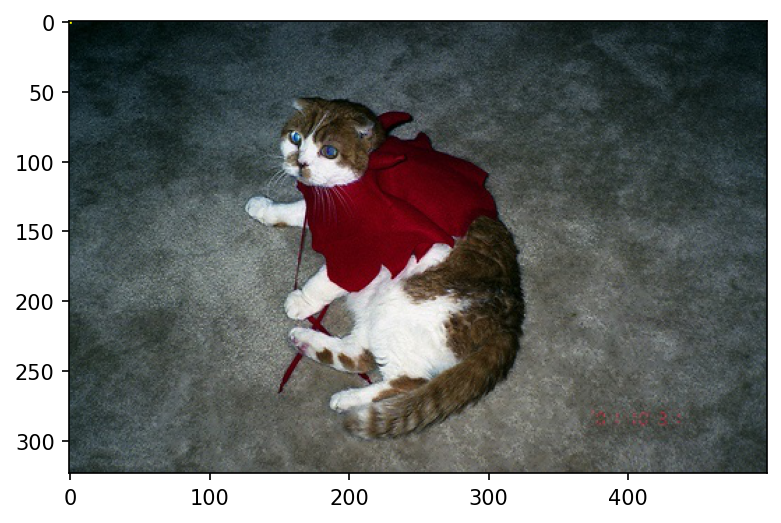

In [154]:
d = VOCDectectionDataset("~/data/", 2007, 'test', region_propose=propose_way, debug=True)
p = d[7][0]
draw_box(p, [[0, 0, 1, 1]])

In [46]:
wsddn = WSDDN_M()
wsddn.pretrain_net._modules['conv3'].weight[1]

tensor([[[ 0.0106, -0.0161, -0.0006],
         [-0.0028, -0.0070,  0.0105],
         [-0.0005,  0.0197,  0.0285]],

        [[-0.0124, -0.0076,  0.0076],
         [-0.0055,  0.0023,  0.0159],
         [-0.0059, -0.0150, -0.0009]],

        [[ 0.0130,  0.0035,  0.0050],
         [-0.0041, -0.0036,  0.0117],
         [ 0.0006,  0.0031,  0.0191]],

        ...,

        [[ 0.0028, -0.0164, -0.0164],
         [ 0.0072, -0.0109, -0.0031],
         [ 0.0004, -0.0013,  0.0158]],

        [[-0.0038, -0.0007, -0.0019],
         [-0.0331, -0.0165,  0.0171],
         [-0.0279, -0.0171,  0.0086]],

        [[-0.0070, -0.0085, -0.0047],
         [-0.0209, -0.0022, -0.0037],
         [-0.0039, -0.0017, -0.0124]]], grad_fn=<SelectBackward>)

In [48]:
wsddn.load_state_dict(torch.load(SAVE_PATH + get_model_name(propose_way, "2007" , f"wsddn_m") + ".pt"))
wsddn.pretrain_net._modules['conv3'].weight[1]

tensor([[[ 0.0106, -0.0161, -0.0006],
         [-0.0028, -0.0070,  0.0105],
         [-0.0005,  0.0197,  0.0285]],

        [[-0.0124, -0.0076,  0.0076],
         [-0.0055,  0.0023,  0.0159],
         [-0.0059, -0.0150, -0.0009]],

        [[ 0.0130,  0.0035,  0.0050],
         [-0.0041, -0.0036,  0.0117],
         [ 0.0006,  0.0031,  0.0191]],

        ...,

        [[ 0.0028, -0.0164, -0.0164],
         [ 0.0072, -0.0109, -0.0031],
         [ 0.0004, -0.0013,  0.0158]],

        [[-0.0038, -0.0007, -0.0019],
         [-0.0331, -0.0165,  0.0171],
         [-0.0279, -0.0171,  0.0086]],

        [[-0.0070, -0.0085, -0.0047],
         [-0.0209, -0.0022, -0.0037],
         [-0.0039, -0.0017, -0.0124]]], grad_fn=<SelectBackward>)

In [6]:
sort_scores, sort_indices = avg_scores.sum(1).sort(descending=True)


In [8]:
sort_indices[:10]

tensor([ 0,  1,  3,  4,  9, 17, 12, 15, 23,  5])

In [4]:
avg_scores = avg_scores[sort_indices[:10], :]

NameError: name 'avg_scores' is not defined

In [11]:
avg_scores[sort_indices[:10], :]

tensor([[3.6908e-06, 2.0964e-06, 8.0518e-06, 2.9449e-07, 2.3122e-06, 7.8836e-07,
         6.0801e-04, 8.6758e-06, 2.2945e-05, 8.8958e-07, 1.4370e-06, 1.6118e-05,
         5.5431e-06, 2.7474e-06, 3.1746e-02, 2.7939e-06, 1.4817e-07, 3.3916e-06,
         3.8567e-06, 3.1236e-06],
        [3.8356e-06, 2.7810e-06, 7.7499e-06, 3.5684e-07, 2.4885e-06, 7.8876e-07,
         6.9919e-04, 8.4128e-06, 2.4483e-05, 1.0064e-06, 1.4698e-06, 1.4905e-05,
         6.6033e-06, 3.4096e-06, 2.7355e-02, 3.0072e-06, 2.0506e-07, 3.0587e-06,
         4.8109e-06, 3.3314e-06],
        [3.8870e-06, 2.1485e-06, 8.8920e-06, 3.7307e-07, 2.9381e-06, 9.7211e-07,
         4.2735e-04, 9.7660e-06, 2.4494e-05, 1.3487e-06, 2.0605e-06, 2.0813e-05,
         6.4251e-06, 3.0106e-06, 2.0944e-02, 2.9605e-06, 1.6793e-07, 3.1937e-06,
         4.2271e-06, 3.5185e-06],
        [4.2085e-06, 4.4335e-06, 8.2102e-06, 5.1850e-07, 3.2877e-06, 1.0479e-06,
         7.3590e-04, 9.4622e-06, 2.8081e-05, 1.3959e-06, 2.0736e-06, 1.8370e-05,
       

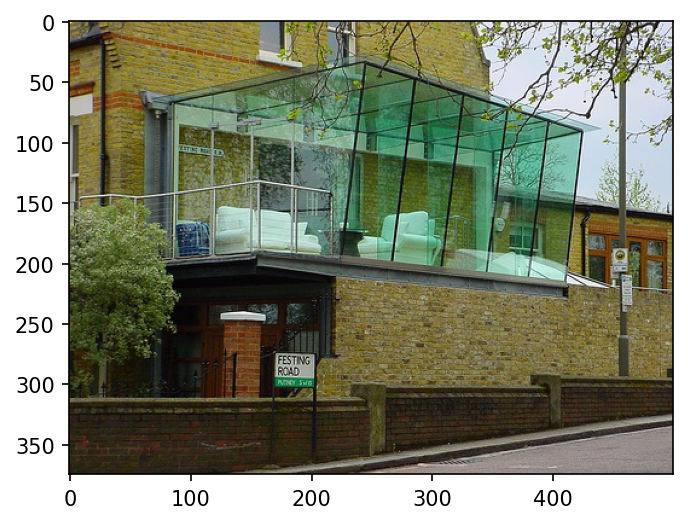

In [57]:
draw_box(p, [[0, 0, 1, 1]])

In [35]:
for i in range(20):
    
    print(str(i) + " : "+ str(s[:, i]))

0 : tensor([6.9416e-07, 1.4790e-07], device='cuda:0', grad_fn=<SelectBackward>)
1 : tensor([3.5129e-05, 9.8570e-06], device='cuda:0', grad_fn=<SelectBackward>)
2 : tensor([2.3328e-05, 8.5027e-06], device='cuda:0', grad_fn=<SelectBackward>)
3 : tensor([4.6591e-08, 9.3474e-09], device='cuda:0', grad_fn=<SelectBackward>)
4 : tensor([2.2372e-05, 6.5169e-06], device='cuda:0', grad_fn=<SelectBackward>)
5 : tensor([1.0007e-06, 2.1655e-07], device='cuda:0', grad_fn=<SelectBackward>)
6 : tensor([0.2399, 0.4481], device='cuda:0', grad_fn=<SelectBackward>)
7 : tensor([1.7425e-05, 6.0871e-06], device='cuda:0', grad_fn=<SelectBackward>)
8 : tensor([0.0138, 0.0090], device='cuda:0', grad_fn=<SelectBackward>)
9 : tensor([1.0136e-08, 2.0020e-09], device='cuda:0', grad_fn=<SelectBackward>)
10 : tensor([6.4067e-06, 1.6790e-06], device='cuda:0', grad_fn=<SelectBackward>)
11 : tensor([0.0003, 0.0001], device='cuda:0', grad_fn=<SelectBackward>)
12 : tensor([1.0509e-04, 3.9917e-05], device='cuda:0', grad_fn

In [36]:
d = VOCDectectionDataset("~/data/", 2007, 'test', debug=True)

In [37]:
b = gt_region[0]

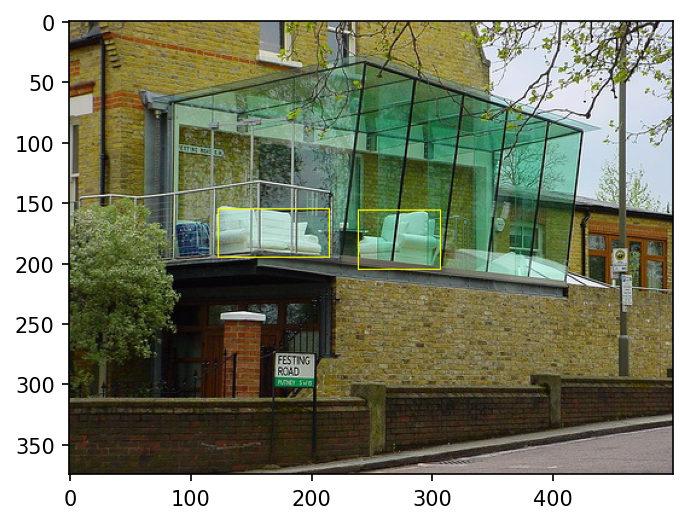

In [38]:
draw_box(d[2][0], b)

In [25]:
total_true_labels

[array([11., 14.], dtype=float32)]

In [76]:
total_pred_boxes[0][89]

array([157., 199., 185., 220.], dtype=float32)

In [36]:
for box in region:
    print(box)

tensor([ 1.,  1., 56., 55.])
tensor([ 1.,  1., 55., 56.])
tensor([ 1.,  1., 56., 56.])
tensor([ 1.,  1., 64., 58.])
tensor([ 1.,  1., 64., 62.])
tensor([ 1.,  1., 82., 63.])
tensor([  1.,   1., 119.,  63.])
tensor([ 1.,  1., 62., 85.])
tensor([  1.,   1., 128.,  85.])
tensor([  1.,   1., 104.,  96.])
tensor([  1.,   1., 151.,  96.])
tensor([  1.,   1., 150., 115.])
tensor([  1.,   1., 162., 117.])
tensor([  1.,   1., 353., 117.])
tensor([  1.,   1., 238., 118.])
tensor([  1.,   1., 353., 182.])
tensor([  1.,   1., 353., 184.])
tensor([  1.,   1., 353., 187.])
tensor([  1.,   1., 223., 278.])
tensor([  1.,   1., 353., 278.])
tensor([  1.,   1., 150., 304.])
tensor([  1.,   1., 151., 305.])
tensor([  1.,   1., 353., 331.])
tensor([  1.,   1., 353., 356.])
tensor([  1.,   1., 353., 435.])
tensor([  1.,   1., 151., 442.])
tensor([  1.,   1., 353., 442.])
tensor([  1.,   1., 216., 448.])
tensor([  1.,   1., 353., 448.])
tensor([  1.,   1., 353., 449.])
tensor([  1.,   1., 353., 452.])
tenso

In [26]:
total_pred_boxes

[array([[199., 199., 220., 220.],
        [182., 182., 207., 207.],
        [192., 192., 227., 227.],
        [116., 116., 215., 215.],
        [157., 157., 213., 213.],
        [171., 171., 194., 194.],
        [169., 169., 215., 215.],
        [197., 197., 219., 219.],
        [184., 184., 213., 213.],
        [136., 136., 232., 232.],
        [194., 194., 216., 216.],
        [126., 126., 247., 247.],
        [124., 124., 166., 166.],
        [118., 118., 176., 176.],
        [109., 109., 133., 133.],
        [116., 116., 196., 196.],
        [153., 153., 173., 173.],
        [144., 144., 175., 175.],
        [141., 141., 168., 168.],
        [212., 212., 242., 242.],
        [144., 144., 171., 171.],
        [116., 116., 137., 137.],
        [100., 100., 145., 145.],
        [203., 203., 232., 232.],
        [134., 134., 165., 165.],
        [175., 175., 246., 246.],
        [ 99.,  99., 174., 174.],
        [106., 106., 162., 162.],
        [ 59.,  59., 221., 221.],
        [141.,

In [22]:
total_pred_scores

[array([1.        , 0.9480776 , 0.8403141 , 0.80685526, 0.7867024 ,
        0.757033  , 0.7133831 , 0.70847565, 0.69017494, 0.53929436,
        0.5260799 , 0.5185317 , 0.51017976, 0.40550065, 0.39557597,
        0.3872023 , 0.38361436, 0.3833996 , 0.3644917 , 0.3555224 ,
        0.33294222, 0.27130914, 0.25043684, 0.24541166, 0.23322098,
        0.22958565, 0.2164175 , 0.20132233, 0.18855172, 0.18397163,
        0.16834788, 0.16477694, 0.15996751, 0.13195257, 0.12130937,
        0.11415108, 0.10847466], dtype=float32)]

In [23]:
total_pred_labels

[array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14], dtype=int32)]

In [24]:
total_true_labels

[array([11., 14.], dtype=float32)]

In [25]:
total_true_boxes

[array([[240.,  48., 371., 195.],
        [ 12.,   8., 498., 352.]], dtype=float32)]

In [90]:
total_pred_labels[5]

array([14, 14, 14, 14], dtype=int32)

In [91]:
total_pred_scores[5]

array([1.        , 0.7002507 , 0.6558719 , 0.18997715], dtype=float32)

In [92]:
total_true_labels[5]

array([8.], dtype=float32)

In [48]:
per_pred_labels

[array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32)]

In [41]:
for i in range(20):
    x = avg_scores[:,i]
    mask = x>0.1
    print(i)
    print(region[mask])

0
tensor([], size=(0, 4))
1
tensor([[ 81., 109., 375., 500.],
        [ 81., 126., 320., 500.],
        [125., 200., 375., 500.],
        [181., 200., 250., 338.],
        [ 41., 204., 295., 500.],
        [ 41., 204., 375., 500.],
        [100., 204., 295., 428.],
        [ 98., 205., 260., 410.],
        [128., 205., 260., 352.],
        [146., 205., 252., 343.],
        [ 98., 215., 168., 410.],
        [ 98., 215., 199., 410.],
        [ 99., 215., 168., 410.],
        [128., 215., 260., 348.],
        [128., 215., 260., 374.],
        [147., 215., 246., 322.],
        [ 98., 219., 165., 410.],
        [ 98., 219., 166., 410.],
        [ 98., 219., 168., 410.],
        [ 98., 219., 171., 425.],
        [150., 219., 247., 309.],
        [ 98., 221., 199., 410.],
        [185., 226., 248., 345.],
        [199., 229., 250., 330.],
        [ 98., 230., 168., 397.],
        [102., 230., 168., 397.],
        [ 99., 231., 168., 390.],
        [ 99., 231., 168., 396.],
        [100., 231.,

In [23]:
region[mask]

tensor([], size=(0, 4))

In [8]:
SAVE_PATH + get_model_name(propose_way, "2007" , "wsddn_s") + ".pt"

'../models/ssw_2007_wsddn_s.pt'

In [4]:
[1, 2, 3][:5]

[1, 2, 3]